In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from torch_geometric.loader import DataLoader
from CustomDataset import CustomDataset

%config InlineBackend.figure_format = 'png2x'
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 'stix' is similar to Times New Roman
# If you want to use LaTeX to render all text (for more consistency)
# plt.rcParams['text.usetex'] = True

plt.rcParams['axes.linewidth'] = 0.5    # Axis line width
plt.rcParams['lines.linewidth'] = 1    # Line width
plt.rcParams['xtick.major.width'] = 0.5  # Set x major tick width to 2 points
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['lines.markersize'] = 4
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [36]:
# Number of time steps
nt = 12

# Number of testing data
test_size = 200

# Number of branches
num_branches = 1991

# Power flow limit
file_path = f'../../data/IEEE_Case1354/branch_params/PF_max_category1.csv'
PF_max_category1 = pd.read_csv(file_path, header=None, index_col=None).to_numpy().astype(bool).flatten()
file_path = f'../../data/IEEE_Case1354/branch_params/PF_max_category2.csv'
PF_max_category2 = pd.read_csv(file_path, header=None, index_col=None).to_numpy().astype(bool).flatten()
file_path = f'../../data/IEEE_Case1354/branch_params/PF_max_category3.csv'
PF_max_category3 = pd.read_csv(file_path, header=None, index_col=None).to_numpy().astype(bool).flatten()

# Set line flow threshold
epsilon = 0.85

PF_max1 = 500
PF_max2 = 1000
PF_max3 = 2000

PF_threshold = np.zeros((num_branches, nt))
PF_threshold[PF_max_category1, :] = epsilon * PF_max1
PF_threshold[PF_max_category2, :] = epsilon * PF_max2
PF_threshold[PF_max_category3, :] = epsilon * PF_max3

In [37]:
# Matrix to store results
branch_flow_true = []
branch_flow_pred = []

over_load_true = []
over_load_pred = []

# Read PF file
for i in range(test_size):
    # Ground truth
    file_path = f'../../res/IEEE_Case1354/model_evaluation/PF/true_corr/true_corr_{i+1}.csv'
    temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    branch_flow_true.append(temp.copy())

    # Prediction
    file_path = f'../../res/IEEE_Case1354/model_evaluation/PF/pred_corr/pred_corr_{i+1}.csv'
    temp = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    branch_flow_pred.append(temp.copy())

# Convert to numpy array
branch_flow_true = np.abs(np.array(branch_flow_true))
branch_flow_pred = np.abs(np.array(branch_flow_pred))

over_load_true = branch_flow_true >= PF_threshold
over_load_pred = branch_flow_pred >= PF_threshold

In [38]:
# Probability of heavying loading
prob_true = over_load_true.mean(axis=0)
prob_pred = over_load_pred.mean(axis=0)

# Get sorted branch index according to mean probability of ground truth
sorted_idx = np.argsort(prob_true.T.mean(axis=0))

# Select six important branches
num_top_branches = 8
top_branch_idx = sorted_idx[-num_top_branches:]

# Sort top branch index
# top_branch_idx = np.sort(top_branch_idx)

top_branch_idx

array([ 523, 1025,  155,  247, 1361, 1360,  105,  296], dtype=int64)

## Failure mode 1 probability: 

$$\mathcal{P}^I_o(t) = p\left( \Gamma_t \right)$$

In [39]:
columns = [f'T={i+1}' for i in range(nt)]
pd.DataFrame(prob_true[top_branch_idx], columns=columns)

,T=1,T=2,T=3,T=4,T=5,T=6,T=7,T=8,T=9,T=10,T=11,T=12
0,0.280,0.210,0.195,0.215,0.205,0.225,0.260,0.215,0.200,0.230,0.245,0.255
1,0.265,0.225,0.185,0.185,0.200,0.255,0.225,0.240,0.205,0.235,0.240,0.280
2,0.465,0.455,0.445,0.460,0.465,0.455,0.470,0.445,0.435,0.420,0.455,0.405
3,0.515,0.520,0.500,0.530,0.510,0.540,0.520,0.525,0.520,0.535,0.535,0.540
4,0.620,0.590,0.545,0.580,0.575,0.585,0.545,0.575,0.605,0.610,0.615,0.595
5,0.900,0.865,0.870,0.875,0.855,0.870,0.855,0.865,0.860,0.830,0.850,0.880
6,0.940,0.910,0.895,0.895,0.910,0.910,0.910,0.910,0.925,0.930,0.915,0.925
7,0.970,0.950,0.940,0.935,0.930,0.920,0.900,0.930,0.900,0.935,0.910,0.940


In [40]:
pd.DataFrame(prob_pred[top_branch_idx], columns=columns)

,T=1,T=2,T=3,T=4,T=5,T=6,T=7,T=8,T=9,T=10,T=11,T=12
0,0.135,0.135,0.100,0.120,0.100,0.110,0.100,0.100,0.075,0.160,0.105,0.075
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.435,0.465,0.440,0.435,0.480,0.485,0.475,0.435,0.405,0.455,0.455,0.410
3,0.190,0.215,0.150,0.145,0.170,0.175,0.165,0.170,0.130,0.250,0.165,0.145
4,0.070,0.020,0.020,0.045,0.030,0.035,0.030,0.015,0.010,0.030,0.030,0.020
5,0.300,0.345,0.320,0.300,0.330,0.330,0.305,0.300,0.220,0.365,0.310,0.270
6,0.125,0.150,0.135,0.145,0.145,0.115,0.105,0.110,0.080,0.120,0.110,0.110
7,0.160,0.185,0.135,0.155,0.150,0.180,0.165,0.175,0.130,0.235,0.135,0.120


## Failure mode 2 probability:

$$\mathcal{P}^{I+}_o(t) = p\left( \bigcup_{t'=t+1}^{t+\Delta T} \Gamma_{t'} \, \vert \, \Gamma_t \right)$$

In [19]:
# Number of time steps
T = 12
delta_T = 2

num_sig_branches = 8

cond_prob_true = np.zeros((num_sig_branches, T))
cond_prob_pred = np.zeros((num_sig_branches, T))

# Calculate conditional probability ground truth
for i in range(num_sig_branches):
    for j in range(T-delta_T):
        idx = over_load_true[:, sorted_idx[-(i+1)], j] == True
        num = (over_load_true[idx, sorted_idx[-(i+1)], j+1:j+1+delta_T] == True).sum(axis=1)
        cond_prob_true[i, j] = (num >= 1).sum() / idx.sum()

# Calculate conditional probability prediction
for i in range(num_sig_branches):
    for j in range(T-delta_T):
        idx = over_load_pred[:, sorted_idx[-(i+1)], j] == True
        num = (over_load_pred[idx, sorted_idx[-(i+1)], j+1:j+1+delta_T] == True).sum(axis=1)
        cond_prob_pred[i, j] = (num >= 1).sum() / idx.sum()

C:\Users\zhay109\AppData\Local\Temp\5\ipykernel_25368\1743512121.py:22: RuntimeWarning: invalid value encountered in scalar divide
  cond_prob_pred[i, j] = (num >= 1).sum() / idx.sum()


In [24]:
pd.DataFrame(cond_prob_true[:, :-delta_T])

,0,1,2,3,4,5,6,7,8,9
0,0.804688,0.814516,0.858407,0.932773,0.917355,0.910569,0.948276,0.933333,0.960317,0.952756
1,0.795082,0.818182,0.935780,0.905983,0.892857,0.930435,0.900901,0.928571,0.939130,0.973684
2,0.771429,0.830769,0.785714,0.887097,0.828571,0.846154,0.910448,0.833333,0.885246,0.878788
3,0.266667,0.500000,0.476190,0.733333,0.666667,0.692308,0.653846,0.772727,0.863636,0.724138
4,0.526316,0.764706,0.812500,0.578947,0.666667,0.769231,0.900000,0.769231,0.800000,0.857143
5,0.391304,0.533333,0.562500,0.600000,0.700000,1.000000,0.727273,0.888889,0.700000,0.777778
6,0.333333,0.500000,0.750000,0.700000,0.875000,0.750000,0.625000,1.000000,1.000000,0.857143
7,0.333333,0.571429,0.833333,0.666667,0.875000,0.750000,0.714286,1.000000,1.000000,0.857143


In [25]:
pd.DataFrame(cond_prob_pred[:, :-delta_T])

,0,1,2,3,4,5,6,7,8,9
0,0.266667,0.555556,0.833333,0.700000,0.777778,0.750000,0.625000,0.666667,1.000000,0.600000
1,0.285714,1.000000,0.666667,0.750000,0.800000,1.000000,0.500000,1.000000,1.000000,0.666667
2,0.000000,NaN,NaN,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.470588,0.812500,0.933333,0.571429,0.687500,0.769231,0.909091,0.666667,0.916667,0.800000
5,0.600000,0.617647,0.714286,0.777778,0.760000,0.888889,0.750000,0.857143,0.827586,0.781250
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Faliure mode 3 probability

$$\mathcal{P}^{II}_o(t) = \left[ p\left( \Gamma_t^j \, \vert \, \Gamma_t^i \right) \right]_{i, j}$$

In [78]:
# List to store results
mode3_prob_true = np.zeros((nt, num_sig_branches, num_sig_branches))
mode3_prob_pred = np.zeros((nt, num_sig_branches, num_sig_branches))

# Calculate conditional probability ground truth
for i in range(nt):
    for j in range(num_sig_branches):
        for k in range(num_sig_branches):
            idx = over_load_true[:, sorted_idx[-(j+1)], i] == True  
            mode3_prob_true[i, j, k] = (over_load_true[idx, sorted_idx[-(k+1)], i] == True).sum() / idx.sum()

# Calculate conditional probability prediction
for i in range(nt):
    for j in range(num_sig_branches):
        for k in range(num_sig_branches):
            idx = over_load_pred[:, sorted_idx[-(j+1)], i] == True  
            mode3_prob_pred[i, j, k] = (over_load_pred[idx, sorted_idx[-(k+1)], i] == True).sum() / idx.sum()

## Failure mode 4 probability

$$\mathcal{P}^{II+}_o(t) = \left[ p\left(\bigcup_{t'=t+1}^{t+\Delta T} \Gamma_{t'}^j \, \vert \, \Gamma_t^i \right) \right]_{i, j}$$

## Risk analysis

#### Failure model 1

In [41]:
# Define cost function
Co = 1 # Cost of overloading, $5/MW

# Calculate the amount of overloading 
branch_overflow_true = np.abs(branch_flow_true - PF_threshold)
branch_overflow_pred = np.abs(branch_flow_pred - PF_threshold)

## Risk associated with overloading at time t
cost_true = branch_overflow_true * Co
cost_pred = branch_overflow_pred * Co
risk_true = cost_true.mean(axis=0).sum(axis=0)
risk_pred = cost_pred.mean(axis=0).sum(axis=0)

#### Failure mode 2

In [42]:
cond_risk_true = np.zeros((num_branches, T))
cond_risk_pred = np.zeros((num_branches, T))

# Calculate conditional probability ground truth
for i in range(num_branches):
    for j in range(T-delta_T):
        idx = over_load_true[:, sorted_idx[-(i+1)], j] == True
        cond_cost_true = branch_overflow_true[:, sorted_idx[-(i+1)], j+1:j+1+delta_T] * Co
        cond_risk_true[i, j] = cond_cost_true.mean(axis=0).sum()
cond_risk_true = cond_risk_true.sum(axis=0)

# Calculate conditional probability prediction
for i in range(num_branches):
    for j in range(T-delta_T):
        idx = over_load_true[:, sorted_idx[-(i+1)], j] == True
        cond_cost_pred = branch_overflow_pred[:, sorted_idx[-(i+1)], j+1:j+1+delta_T] * Co
        cond_risk_pred[i, j] = cond_cost_pred.mean(axis=0).sum()
cond_risk_pred = cond_risk_pred.sum(axis=0)

#### Overall risk

In [43]:
overall_risk_true = risk_true + cond_risk_true
overall_risk_pred = risk_pred + cond_risk_pred

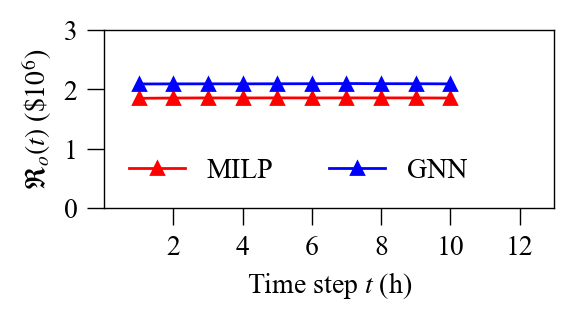

In [47]:
# Plot overall risk
x = np.arange(1, 11)

fig = plt.figure(figsize=(3, 1.75))
ax = fig.add_subplot(111)
ax.plot(x, overall_risk_true[:-delta_T]/1e6, color='red', marker='^', label='MILP')
ax.plot(x, overall_risk_pred[:-delta_T]/1e6, color='blue', marker='^', label='GNN')
ax.set_xlabel('Time step $t$ (h)')
ax.set_xlim((0, 13))
ax.set_xticks([2, 4, 6, 8, 10, 12])
ax.set_ylim((0, 3))
ax.set_ylabel('$\Re_o(t)$ ($\$10^6$)')
ax.legend(ncols=2, frameon=False)

plt.tight_layout()
plt.show()
plt.close('all')
